In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from datetime import datetime, timedelta, date

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from time import time
import logging

In [2]:
print("Start linear regression...")
t0 = time()
t1 = time()

dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')

data = pd.read_csv('WeatherData_Demand.csv',sep=",",parse_dates=['date'],date_parser=dateparse)
#data = pd.read_csv('BikeUsageByDayAndStationInOut2.csv',sep=";")
#print(data.head())
#print('\n Data Types:')
# print(data.dtypes)

data = data.rename(index=str, columns={"totaldemand":"label"})
# print(data.dtypes)

print("Read11 data in %0.3fs" % (time() - t1))

Start linear regression...
Read11 data in 0.025s


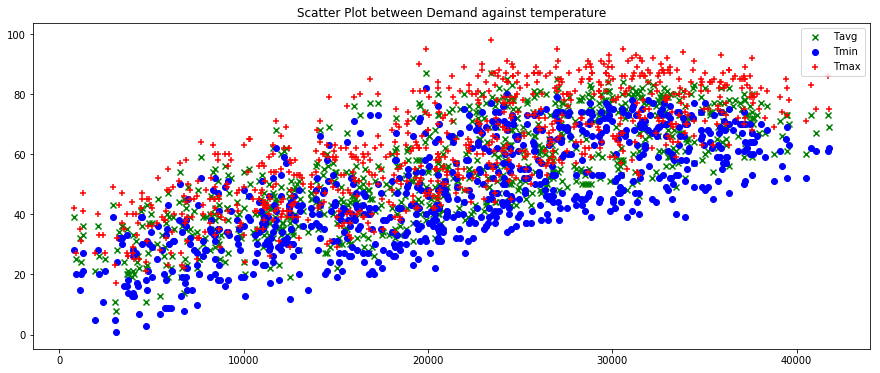

In [3]:
X = data['label']
Y = data['tavg']
Y2 = data['tmin']
Y3 = data['tmax']

tavg = plt.scatter(X,Y, c="g", marker="x", )
tmin = plt.scatter(X,Y2, c="b", marker="o")
tmax = plt.scatter(X,Y3, c="r", marker="+")

plt.legend((tavg,tmin,tmax), ('Tavg', 'Tmin', 'Tmax'))
        
name = "Scatter Plot between Demand against temperature"
plt.title(name)
plt.show()

In [4]:
# We don't need tmin and tmax (correlated)
data.drop('tmin', axis =1, inplace=True)
data.drop('tmax', axis =1, inplace=True)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime, timedelta, date

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from time import time
import logging

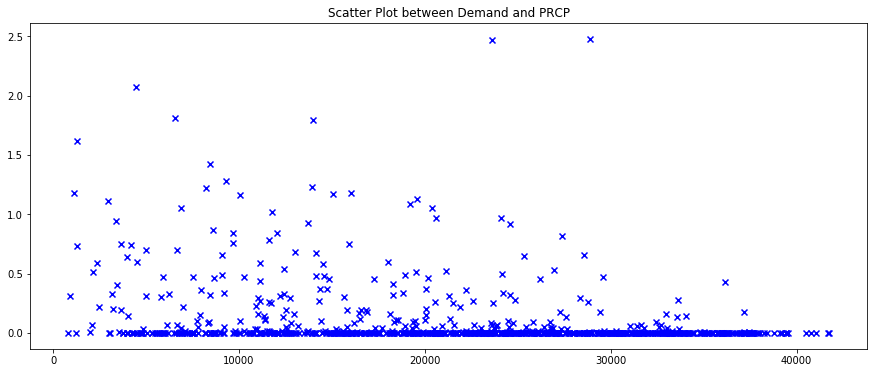

In [6]:
X = data['label']
Y = data['prcp']

plt.scatter(X,Y, c="b", marker="x")

        
name = "Scatter Plot between Demand and PRCP"
plt.title(name)
plt.show()

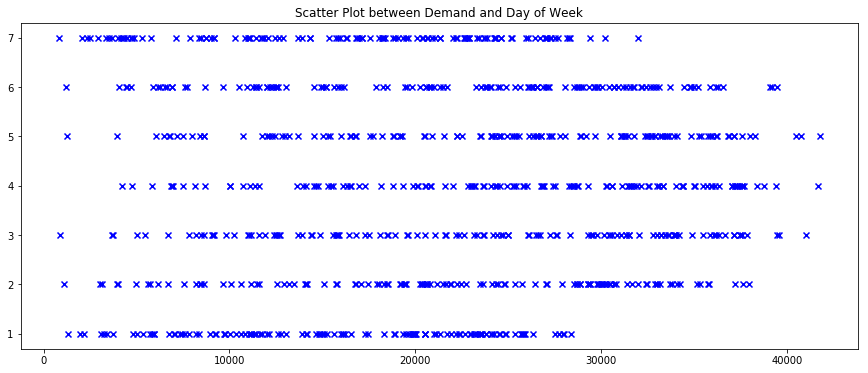

In [7]:
X = data['label']
Y = data['dayofweek']

plt.scatter(X,Y, c="b", marker="x")

        
name = "Scatter Plot between Demand and Day of Week"
plt.title(name)
plt.show()

In [8]:
# We don't need snow and precipitation is correlated
#data.drop('snow', axis =1, inplace=True)
#data.drop('snwd', axis =1, inplace=True)



In [9]:
spark = SparkSession.builder.master("local").enableHiveSupport().getOrCreate()


In [10]:
# from pyspark.sql import SparkSession

from pyspark.ml import Pipeline

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler

from pyspark.ml.regression import LinearRegression

In [11]:
# Assembler of Features
assembler = VectorAssembler(
    inputCols=['dayofweek', 'prcp', 'snow', 'snwd', 'tavg', #'tmax', 'tmin',
              'wt01_boolean', 'wt02_boolean', 'wt03_boolean', 'wt04_boolean',
               'wt06_boolean', 'wt08_boolean', 'wt09_boolean'],
   #inputCols=['dayofweek', 'tavg'],
    outputCol="features")

In [12]:
# Create a StandardScaler for the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                      withStd=True, withMean=False)

In [13]:
# Define Linear Regression
lr = LinearRegression(featuresCol="scaledFeatures", maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [14]:
# Define Pipeline
lr_pipeline = Pipeline(stages=[assembler, scaler, lr])

In [15]:
# Convert to Spark DataFrame
data_clean = data.dropna()
dataDF = spark.createDataFrame(data_clean)


In [16]:
print("Fitting linear regression...")
t1 = time()
lrModel = lr_pipeline.fit(dataDF)
print(" in %0.3fs" % (time() - t1))

Fitting linear regression...
 in 4.800s


In [17]:
lrModel.write().overwrite().save("hdfs://ussm-mag-hdpc01.lab.opentext.com/opentext/models/forecast_with_weather_mb")